# Can TF-IDF scores help to distinguish human-written essays and AI-generated essays?

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import spacy
from spacy import displacy
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.stats import ttest_ind, chi2_contingency, ranksums, wilcoxon

# Introduction

In this intriguing data analysis project, I aim to investigate the distinctiveness in word usage between AI-generated and human-written essays. My objective is to determine if there are notable differences in the way words are employed in these two types of essays. To achieve this, I will be calculating the **TF-IDF (Term Frequency-Inverse Document Frequency)** scores for words found in both AI-generated and human-written essays. By delving into this analysis, we can uncover fascinating insights into the linguistic nuances between AI and human language, sparking curiosity and further exploration into the evolving realm of artificial intelligence and human creativity.

## Background Information

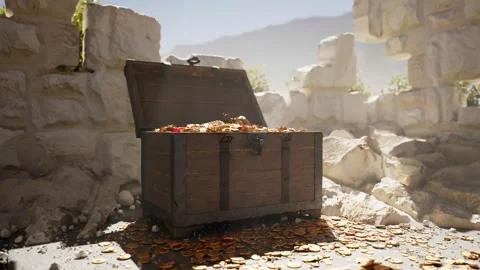


**What is TF-IDF?**  

Imagine you have a big collection of books, and you want to find out which words are the most important in each book. TF-IDF helps us do that.

TF stands for Term Frequency, which is just a fancy way of saying how many times a word appears in a book. If a word like "adventure" appears a lot in a book about travel, its TF score for that book would be high.  

IDF stands for Inverse Document Frequency. This part is about how rare or common a word is across all the books. If a word like "the" appears in every book, it's not very unique. So, its IDF score is low. But if a word like "peregrination" (which means a long journey) appears in only a few books, its IDF score is high.  

Now, when you multiply TF and IDF together, you get TF-IDF. This gives you a score for each word in each book, showing how important or unique that word is to that book.  

In simpler terms, TF-IDF helps us figure out which words are special and meaningful in a book compared to all the other books. It's like finding the diamonds in a treasure chest full of rocks!


## Previous research

In the paper "Distinguishing Academic Science Writing from Humans or ChatGPT with over 99% Accuracy Using Off-the-Shelf Machine Learning Tools," [1] the author explores methods for distinguishing between human and AI-generated writing with remarkable accuracy. One key finding from their research is the identification of "popular words" as a significant distinguishing feature.

Inspired by their work and seeking to further validate their findings, I have obtained a dataset from Kaggle and intend to employ a different method, namely TF-IDF (Term Frequency-Inverse Document Frequency), to measure the prominence of these "popular words." By leveraging this widely-used technique, I aim to contribute new insights and perspectives to the ongoing discourse on distinguishing human writing from AI-generated content.


# Research Question

During this data assignment, I aim to investigate and address the following questions.

**1. Can the TF-IDF matrix be used to train a SVM (Support Vector Machine) model to distinguish whether an essay is a human-written essay or an AI-generated essay?**  

**2. Is there any differences between words that been used in human-written essay and AI-generated essay based on the coefficient we got from trained SVM?**  


# Data

The dataset I've obtained from Kaggle, named "[LLM-Detect AI Generated Text Dataset](https://www.kaggle.com/datasets/sunilthite/llm-detect-ai-generated-text-dataset/data)," was originally designed to train models for distinguishing essays written by students from those generated by an LLM. However, I'm repurposing this dataset to validate my research question regarding the significant differences between human-written and AI-generated essays. This step is crucial in assessing whether TF-IDF can serve as a distinguishing feature to detect whether an essay was authored by a human or AI.  

The dataset comprises two columns:
*   text: This column contains the essay text, which could be either human-generated or AI-generated.
*   generated: This column serves as the target label, indicating whether the text was generated by a human (labeled as 0) or AI (labeled as 1).  

By analyzing this dataset and applying TF-IDF as a metric, I aim to shed light on the distinct characteristics of human and AI-generated writing. If successful, this could pave the way for using TF-IDF as a feature for future essay detection systems, enhancing our ability to discern between human and AI-authored content.



## *Sidenote

I believe this dataset can still be utilized effectively despite the lack of detailed information about its collection process and origin. Here are my reasons:

1. I attempted to find a better dataset to replace the one I currently use, specifically one provided by Scott from the Learning Agency Lab. However, upon examining Scott's data, I discovered that the training data had extremely unbalanced labels for human and AI. Out of a total of 1376 rows, only 1 was labeled as AI-generated. In contrast, the dataset I am currently using is quite balanced, with a substantial amount of data available for analysis. While having more balanced data is preferable, the superior source does not align with the specific goals of my class assignment. Hence, I opted to use the current dataset.

2. I have always been intrigued by the topic of distinguishing between AI and human-generated text, especially since ChatGPT gained popularity. Education serves a vital purpose, and without a supervised system to identify AI-generated text, students might inadvertently rely too heavily on AI without critical thinking. Therefore, my intention is rooted in a desire to contribute positively by applying what I have learned in this class.

3. I discussed my concerns about using this dataset, given its lack of clear information, with Scott twice and Jess once. Both of them reviewed the data and the results from my initial data assignment, and they assured me that it was acceptable to use this dataset. As a result, I have decided to proceed with utilizing it.

# Data Wrangling

During the data wrangling phase, I performed the following key steps:

1. **Exploratory Data Analysis (EDA)**: I conducted an in-depth analysis of the original dataset to gain insights into its structure, understand the nature of the data, identify any potential data cleaning or processing requirements, and formulate strategies for data utilization.

2. **Data Processing**: Building upon the insights gained from EDA, I executed data processing tasks to prepare the dataset for further analysis. This involved removing duplicate entries and downsizing the number of essays labeled as 0 (not AI generated) to achieve a balanced dataset.

The primary objectives of this phase were to ensure data integrity, address any anomalies or inconsistencies, and create a well-prepared dataset that is ready for subsequent analysis and modeling.



## EDA

In [2]:
raw_essays = pd.read_csv('/content/drive/MyDrive/NLP-2024Spring/NLP-Project/data/Training_Essay_Data.csv', encoding="utf_8") # read in the data using utf_8 encoding
raw_essays.shape # print out the shape of the data how see how many rows and columns in the data

(29145, 2)

In [3]:
raw_essays.head() # print out the first 5 rows to get a glance of the data

,text,generated
0,Car-free cities have become a subject of incre...,1
1,"Car Free Cities Car-free cities, a concept ga...",1
2,A Sustainable Urban Future Car-free cities ...,1
3,Pioneering Sustainable Urban Living In an e...,1
4,The Path to Sustainable Urban Living In an ...,1


In [4]:
raw_essays.info() # print info() of the data, to check the basic states of the data
# no null values, which is great

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29145 entries, 0 to 29144
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       29145 non-null  object
 1   generated  29145 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 455.5+ KB


In [5]:
# an example of the text
raw_essays.text[0]

# There are many punctuations, for TF-IDF, we do not need them since we are calculating the words related matric
# There are uppercases. We will lower them.

"Car-free cities have become a subject of increasing interest and debate in recent years, as urban areas around the world grapple with the challenges of congestion, pollution, and limited resources. The concept of a car-free city involves creating urban environments where private automobiles are either significantly restricted or completely banned, with a focus on alternative transportation methods and sustainable urban planning. This essay explores the benefits, challenges, and potential solutions associated with the idea of car-free cities.  Benefits of Car-Free Cities  Environmental Sustainability: Car-free cities promote environmental sustainability by reducing air pollution and greenhouse gas emissions. Fewer cars on the road mean cleaner air and a significant decrease in the contribution to global warming.  Improved Public Health: A reduction in automobile usage can lead to better public health outcomes. Fewer cars on the road result in fewer accidents and a safer urban environme

<Axes: xlabel='generated'>

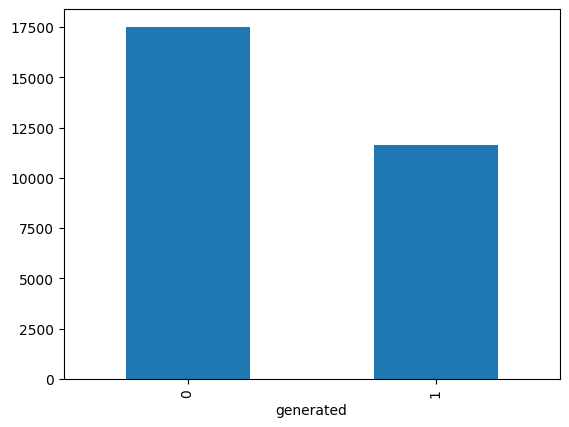

In [6]:
%matplotlib inline

raw_essays["generated"].value_counts().plot(kind='bar')

# This dataset has more human essays than AI generated essays. (about 5000 essays)
# To lower the bias of the model, we will apply down sampling for 0 (the human generated essays)

In [7]:
raw_essays["generated"].value_counts()

generated
0    17508
1    11637
Name: count, dtype: int64

In [8]:
17508 - 11637

5871

### text duplications

In [9]:
raw_essays['text'].describe()
# it is important to check whether there are duplicates, since it will affect
# the model later if we do not remove duplicates

# there are 29145 essays in the data, but 27340 essays are unique
# TO-DO: We need to figure out which label they have, and how to deal with them
# / or we can just ignore them, only use data with unique values

count                                                 29145
unique                                                27340
top       Cars are not the most important thing in our l...
freq                                                      3
Name: text, dtype: object

<Axes: xlabel='generated'>

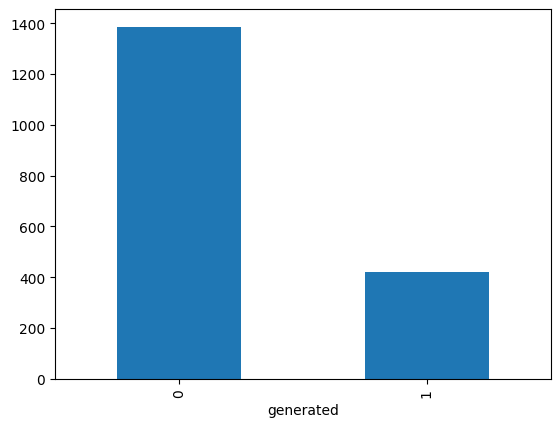

In [10]:
%matplotlib inline

# Both human wroten essays and AI generated essays are having duplications
#     Possible reason: since they are from online classes, students might resubmit them
# So, I decided to just delete those duplications.
duplicate_data = raw_essays[raw_essays['text'].duplicated() == True]
duplicate_data["generated"].value_counts().plot(kind='bar')

In [11]:
duplicate_data["generated"].value_counts()

generated
0    1386
1     419
Name: count, dtype: int64

## Data cleaning

### delete duplicates

In [37]:
essay = raw_essays.drop_duplicates(subset='text')
essay.shape
# We want to drop those rows that are having the exact same text.
#   Although, in this dataset, drop duplicates and drop duplicates based on 'text' are the same.
#   In other cases there might be rows that are having the same text but different labels, I think
#   there is no point to keep them since our research questions are comparing the Phrasal Complexity
#   differencies between human written essays and AI generated essays.

(27340, 2)

In [13]:
essay['generated'].value_counts() # to see how many essays for each label left

generated
0    16122
1    11218
Name: count, dtype: int64

### downsize the data

Encoding the original data with 27340 rows took more than half hour, so we decided to downsize the data.  
We choose 5000 essays each from human essays and AI generated essays.

In [28]:
# random sample 5000 essays from each label
# human_essay = essay.loc[essay["generated"] == 0].sample(n=10000)
# ai_essay = essay.loc[essay['generated']==1].sample(n=10000)

In [29]:
# conbine 5000 essays from each label to gether into one table
# sm_essay = pd.concat([human_essay, ai_essay], ignore_index=True, axis=0)
# sm_essay.head()

,text,generated
0,Getting advice is crucial to success. No matte...,0
1,Dear : Principal\n\nI think that would be a gr...,0
2,"""So Mr. Ashwalt now that you've read the artic...",0
3,It's not a secret that we as humans use cars t...,0
4,Phones and Driving: The Dangerous of Both at O...,0


In [39]:
###### if use GPU
sm_essay = essay

In [40]:
sm_essay.shape # double check we have the right dimentions

(27340, 2)

In [41]:
sm_essay["generated"].value_counts() # double check we have right number of essays for each label

generated
0    16122
1    11218
Name: count, dtype: int64

# NLP Analysis

**To refresh the memory of my research question**:  
Can the TF-IDF matrix be used to train a model to distinguish whether an essay is a human-written essay or an AI-generated essay?

**Data Preparation**:
1. **Tokenization**: Tokenizing the text involves breaking it down into individual words or tokens so that the computer can process them.
2. **TF-IDF Vectorization**: Utilizing TfidfVectorizer from the sklearn library to convert the tokenized text into a TF-IDF matrix, capturing the importance of words in each essay based on their frequency and rarity across the dataset.
3. **Word Frequency Distribution Visualization**: Visualizing the word frequency distribution can help determine an appropriate min_df value, setting a threshold for the minimum number of times a word must appear to be included in the TF-IDF matrix.

**Modeling**:
1. **Train-Test Data Split**: Splitting the dataset into training and testing sets to evaluate the model's performance on unseen data.
2. **Classification Models**: Considering various classification algorithms such as logistic regression, random forest, support vector machine (SVM), and k-means to train and evaluate their effectiveness in distinguishing between human-written and AI-generated essays.
3. **Model Evaluation**: Assessing the accuracy, precision, recall, and F1-score of each model to determine which one performs best for the given task.


## Data Preparation

In [33]:
# import torch
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Tokenization

Usually we tokenize it here, but here we want to wait until we split the data into the training and test dataset.

The reason we still do it here is to help me check how long it will take me to tokenize the whole dataset. If it takes too long, we might want to narrow it down to a smaller dataset.

In [42]:
from spacy.lang.en.stop_words import STOP_WORDS

activated = spacy.prefer_gpu()

# Load English tokenizer. We don't need the parser or named entity recognition for this task, so we can leave them out.
nlp = spacy.load('en_core_web_sm', exclude=["parser", "ner"])

# We will need to provide a tokenization function to our vectorizers
# You just need to provide the docs object and add lowercase=False to your vectorizers
# to prevent the vectorizers from trying to do any string processing before tokenization

def tokenize_docs(doc):
  tokens = [tok.lemma_.lower() for tok in doc if not tok.is_punct and not tok.is_space]
  return [tok for tok in tokens if tok not in STOP_WORDS]

# Convert the texts into a list of docs using nlp.pipe()
docs = list(nlp.pipe(sm_essay.text))

In [27]:
#### If you have GPU, set it to gpu

### TF-IDF Vectorization

We will set `min_df=5` to help to get rid of some of those words with very low frequency.

Here it is just to visualize how the dataset looks like when we use TFIDF vectorizer.

The actuall TF-IDF vectorization does not happy here. We only initialize it here and later we will include it into our pipeline and fit it to our training dataset.

In [43]:
from sklearn.feature_extraction.text import TfidfVectorizer
# Initialize the vectorizer
tfidf_vectorizer = TfidfVectorizer(tokenizer=tokenize_docs, token_pattern=None, lowercase=False, min_df=5)
# Fit it to the data
X = tfidf_vectorizer.fit_transform(docs)
# Output a dataframe
tfidf_df = pd.DataFrame(X.toarray())
tfidf_df.columns = tfidf_vectorizer.get_feature_names_out()
print(f'Dataframe Shape: {tfidf_df.shape}')
tfidf_df

Dataframe Shape: (27340, 14273)


,"""(duffer","""(paragraph","""(plumer","""(posner","""(rosenthal","""(selsky","""(source","""(the","""a","""all",...,then,we,¨,¨a,¨the,¨twin¨,®,°,´,’
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27335,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
27336,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
27337,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.099122
27338,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.139039


### Word Frequency Distribution Visualization


Text(0.5, 1.0, 'Word Frequency Distribution')

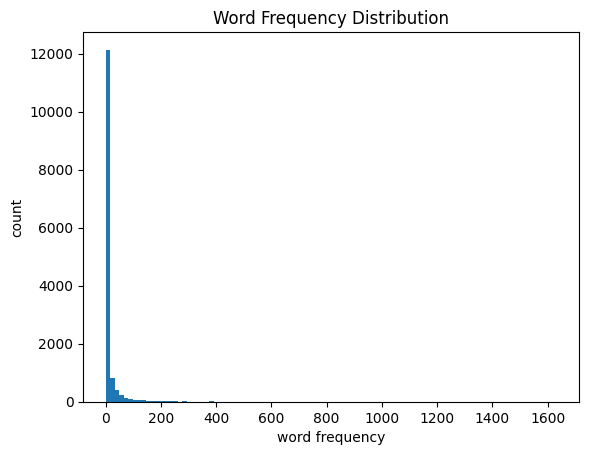

In [44]:
import matplotlib.pyplot as plt
tfidf_df.sum().plot.hist(bins=100)
plt.xlabel('word frequency')
plt.ylabel('count')
plt.title('Word Frequency Distribution')

## Modeling

In the paper, we only consider using SVM based on Scott's suggestion. So for fiting the model, you can just skip all the other models, just run SVM.

#### Train-Test Data Split

In [46]:
# sklearn has a package to split the data into train and test groups
from sklearn.model_selection import train_test_split
seed = 42 # set your random seed

activated = spacy.prefer_gpu()

# Load English tokenizer. We don't need the parser or named entity recognition for this task, so we can leave them out.
nlp = spacy.load('en_core_web_sm', exclude=["parser", "ner"])

X = sm_essay['text'] # the features we want to analyze
ylabels = sm_essay['generated']

# the labels, or answers, we want to test against
X_train, X_test, y_train, y_test = train_test_split(X, ylabels, test_size=0.2, random_state = seed)

In [ ]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

In [55]:
X_train = list(nlp.pipe(X_train))
X_test = list(nlp.pipe(X_test))

count                                                 27340
unique                                                27340
top       Car-free cities have become a subject of incre...
freq                                                      1
Name: text, dtype: object

#### Fitting the Model & Evaluation

I will use sklearn's Pipeline class to organize and optimize the machine learning process.

Models that I will use:
- logistic regression model
- random forest
- svm model
- k-means clustering

Later, we will compare those models and its accuracy.

##### *Logistic Regrassion

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

classifier = LogisticRegression()

# When we are doing a multistep process in sklearn, it's best to set it up as a pipeline
pipe = Pipeline([('vectorizer', tfidf_vectorizer),
                 ('classifier', classifier)])

pipe.fit(X_train, y_train)

Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(lowercase=False, min_df=5, token_pattern=None,
                                 tokenizer=<function tokenize_docs at 0x7a1e10325750>)),
                ('classifier', LogisticRegression())])

###### accuracy

In [ ]:
from sklearn import metrics
# Predicting with a test dataset
predicted = pipe.predict(X_test)# Model Accuracy
print("Logistic Regression Accuracy:",metrics.accuracy_score(y_test, predicted))
print("Logistic Regression Precision:",metrics.precision_score(y_test, predicted))
print("Logistic Regression Recall:",metrics.recall_score(y_test, predicted))

Logistic Regression Accuracy: 0.98
Logistic Regression Precision: 0.9826883910386965
Logistic Regression Recall: 0.9767206477732794


              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1012
           1       0.98      0.98      0.98       988

    accuracy                           0.98      2000
   macro avg       0.98      0.98      0.98      2000
weighted avg       0.98      0.98      0.98      2000



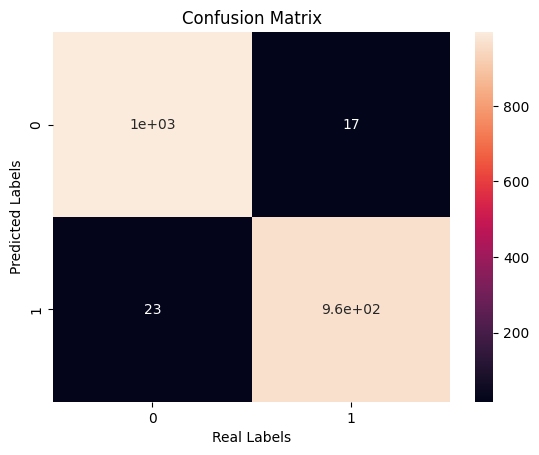

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
# Check out a classification report
print(metrics.classification_report(y_test, predicted))

# We can also look at incorrect predictions in a confusion matrix heatmap
cm = metrics.confusion_matrix(y_test, predicted)
sns.heatmap(cm, annot=True)
plt.title('Confusion Matrix')
plt.xlabel('Real Labels')
plt.ylabel('Predicted Labels')
plt.show()

###### [Answer for the 1st research question]

Just to remind you of my first research question: "Can the TF-IDF matrix be used to train a model to distinguish whether an essay is a human-written essay or an AI-generated essay?"

Based on the accuracy I obtained from this simple classification model, the Logistic Regression model, I conclude that **the TF-IDF matrix can indeed be used to train a model to distinguish whether an essay is human-written or AI-generated**.


**Moving on to the next step**:  
Since my second research question is whether other classification models such as Random Forest, SVM (Support Vector Machine), or K-means can better predict whether an essay is generated by a human or AI, we will now delve into comparing these models and their predictive capabilities.

##### *Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

rf_pipe = Pipeline([('vectorizer', tfidf_vectorizer),
                 ('classifier', rf_classifier)])

rf_pipe.fit(X_train, y_train)

Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(lowercase=False, min_df=5, token_pattern=None,
                                 tokenizer=<function tokenize_docs at 0x7a1e10325750>)),
                ('classifier', RandomForestClassifier(random_state=42))])

###### accuracy

In [ ]:
from sklearn import metrics
# Predicting with a test dataset
predicted = rf_pipe.predict(X_test)# Model Accuracy
print("Random Forest Accuracy:",metrics.accuracy_score(y_test, predicted))
print("Random Forest Precision:",metrics.precision_score(y_test, predicted))
print("Random Forest Recall:",metrics.recall_score(y_test, predicted))

Random Forest Accuracy: 0.98
Random Forest Precision: 0.985655737704918
Random Forest Recall: 0.9736842105263158


              precision    recall  f1-score   support

           0       0.97      0.99      0.98      1012
           1       0.99      0.97      0.98       988

    accuracy                           0.98      2000
   macro avg       0.98      0.98      0.98      2000
weighted avg       0.98      0.98      0.98      2000



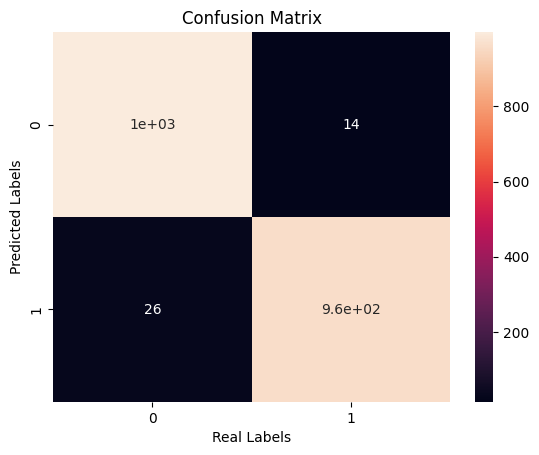

In [ ]:
# Check out a classification report
print(metrics.classification_report(y_test, predicted))

# We can also look at incorrect predictions in a confusion matrix heatmap
cm = metrics.confusion_matrix(y_test, predicted)
sns.heatmap(cm, annot=True)
plt.title('Confusion Matrix')
plt.xlabel('Real Labels')
plt.ylabel('Predicted Labels')
plt.show()

##### SVM

In [48]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC

svm_classifier = SVC(kernel='linear', C=1.0, random_state=42)

svm_pipe = Pipeline([('vectorizer', tfidf_vectorizer),
                 ('classifier', svm_classifier)])

svm_pipe.fit(X_train, y_train)

Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(lowercase=False, min_df=5, token_pattern=None,
                                 tokenizer=<function tokenize_docs at 0x78390b5afac0>)),
                ('classifier', SVC(kernel='linear', random_state=42))])

###### accuracy

In [52]:
from sklearn import metrics

# Predicting with a test dataset
predicted = svm_pipe.predict(X_test)# Model Accuracy
print("SVM Accuracy:",metrics.accuracy_score(y_test, predicted))
print("SVM Precision:",metrics.precision_score(y_test, predicted))
print("SVM Forest Recall:",metrics.recall_score(y_test, predicted))

SVM Accuracy: 0.9899414776883687
SVM Precision: 0.9927992799279928
SVM Forest Recall: 0.9826280623608018


              precision    recall  f1-score   support

           0       0.99      1.00      0.99      3223
           1       0.99      0.98      0.99      2245

    accuracy                           0.99      5468
   macro avg       0.99      0.99      0.99      5468
weighted avg       0.99      0.99      0.99      5468



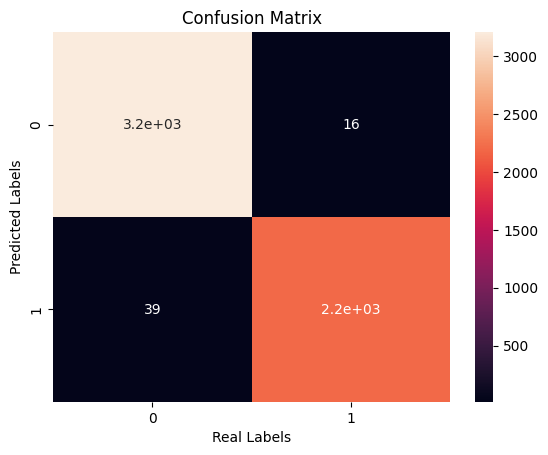

In [53]:
import seaborn as sns

# Check out a classification report
print(metrics.classification_report(y_test, predicted))

# We can also look at incorrect predictions in a confusion matrix heatmap
cm = metrics.confusion_matrix(y_test, predicted)
sns.heatmap(cm, annot=True)
plt.title('Confusion Matrix')
plt.xlabel('Real Labels')
plt.ylabel('Predicted Labels')
plt.show()

##### *K-means

In [ ]:
from sklearn.cluster import KMeans

kmeans_classifier = KMeans(n_clusters=2, random_state=42)

kmeans_pipe = Pipeline([('vectorizer', tfidf_vectorizer),
                 ('classifier', kmeans_classifier)])

kmeans_pipe.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(lowercase=False, min_df=5, token_pattern=None,
                                 tokenizer=<function tokenize_docs at 0x7a1e10325750>)),
                ('classifier', KMeans(n_clusters=2, random_state=42))])

###### accuracy

In [ ]:
from sklearn import metrics
# Predicting with a test dataset
predicted = kmeans_pipe.predict(X_test)# Model Accuracy
print("kmeans Accuracy:",metrics.accuracy_score(y_test, predicted))
print("kmeans Precision:",metrics.precision_score(y_test, predicted))
print("kmeans Recall:",metrics.recall_score(y_test, predicted))

kmeans Accuracy: 0.4605
kmeans Precision: 0.28019323671497587
kmeans Recall: 0.058704453441295545


              precision    recall  f1-score   support

           0       0.48      0.85      0.62      1012
           1       0.28      0.06      0.10       988

    accuracy                           0.46      2000
   macro avg       0.38      0.46      0.36      2000
weighted avg       0.38      0.46      0.36      2000



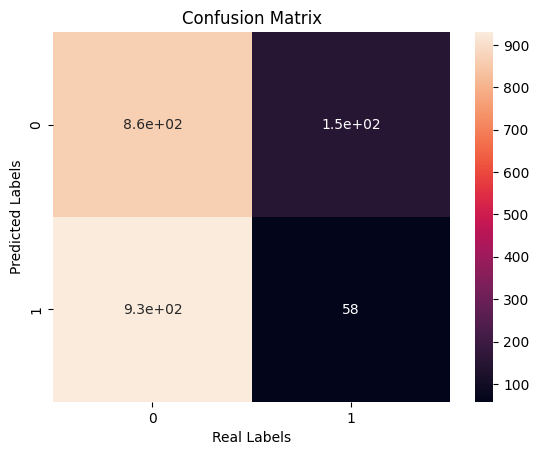

In [ ]:
# Check out a classification report
print(metrics.classification_report(y_test, predicted))

# We can also look at incorrect predictions in a confusion matrix heatmap
cm = metrics.confusion_matrix(y_test, predicted)
sns.heatmap(cm, annot=True)
plt.title('Confusion Matrix')
plt.xlabel('Real Labels')
plt.ylabel('Predicted Labels')
plt.show()

# Statistical Analysis

## Model performance

Since we know SVM will have best performance, during the paper, we did not compare it with other models.

| Model            | Accuracy | Precision | Recall |FP | FN |
|------------------|----------|-----------|--------|-----------|--------|
| Logistic Regression | 0.98    | 0.983      | 0.977   |23      | 17   |
| Random Forest       | 0.98    | 0.986      | 0.974   |26     | 14   |
| **SVM**       | **0.9855**   | **0.989**      | **0.982**   |**18**      | **11**   |
| K-Means             | 0.4605    | 0.280      | 0.059   |930      | 150   |

Tabel 1: Compare different scores for models that I explored above.

## *[Answer for the 2nd research question]

Just to remind you of my second research question:
"If the first research question is yes, which classification model from Logistic Regression, Random Forest, SVM (Support Vector Machine), K-means, can be used to better predict whether the essay is generated by a human or AI?"

Based on the table above comparing the overall performance of these models, SVM has the highest scores across various metrics. Accuracy, being the most obvious indicator of model performance, shows that SVM has the highest accuracy value. Therefore, I conclude that **SVM is the best model for our data compared to Logistic Regression, Random Forest, and K-Means**.

**Moving forward**:  
Since my third research question is whether there are any differences between words used in human-written essays and AI-generated essays based on the best-performing model identified in the second research question, my next step is to analyze the SVM coefficients to determine these differences.

## Coefficients for Words in Each Label

Each coefficient shows the how strongly the word discriminates between the two labels.
1. The lower coefficients tending to classify the essay into label 0
2. The higher coefficients tending to classify the essay into label 1


In [56]:
coef_df = pd.DataFrame({'coefficients':list(svm_classifier.coef_.toarray().flatten()), 'vocabulary': list(pd.DataFrame(tfidf_vectorizer.vocabulary_, index=[0]).T.sort_values(0).index)})

# take the lowest coefficients
lowest = coef_df.sort_values(by='coefficients').head(20).reset_index(drop=True)
lowest.columns = [col+'_human' for col in lowest.columns]

# take the highest coefficients
highest = coef_df.sort_values(by='coefficients').tail(20).sort_values(by='coefficients', ascending=False).reset_index(drop=True)
highest.columns = [col+'_ai' for col in highest.columns]

# put them together to compare
pd.concat([lowest, highest], axis=1)

,coefficients_human,vocabulary_human,coefficients_ai,vocabulary_ai
0,-2.646390,s,3.444422,additionally
1,-2.299887,kid,3.426656,ensure
2,-2.293150,cause,3.424241,potential
3,-2.213645,want,2.686527,capacity
4,-2.160675,people,2.557110,provide
5,-2.127275,human,2.533817,informed
6,-2.064951,accomplish,2.342978,essential
7,-1.898977,planet,2.325653,academic
8,-1.851164,thing,2.322263,climate
9,-1.817547,venus,2.274153,consider


## [Answer for the 3rd reserch question]

Upon comparing the top 20 vocabularies commonly used in human-written essays (vocabulary_human) with those used in AI-generated essays (vocabulary_ai), it becomes evident that the vocabulary in AI-generated essays leans more towards academic language compared to the vocabulary in  essays human-written.

To delve deeper into these words, I aim to examine their morphological features independently of their context within sentences. This analysis will shed light on the inherent differences between the vocabulary used in human-written essays and that used in AI-generated essays.

### Morphology perspective

Firstly, I will split the words in the coefficient dataset into the human_coef dataset if their coefficients are less than or equal to -0.5; otherwise, I will place them in the ai_coef dataset if their coefficients are greater than or equal to 0.5. The rationale behind choosing -0.5 and 0.5 will be explained below.

Next, I will gather the morphological features for each tokenized word in both the human_coef and ai_coef datasets.

Finally, I will create a paired bar plot to visually depict how each morphology tag is used in the different datasets of human-written text versus AI-generated text. This plot aims to illustrate the contrasts in morphological usage between human and AI-generated content.

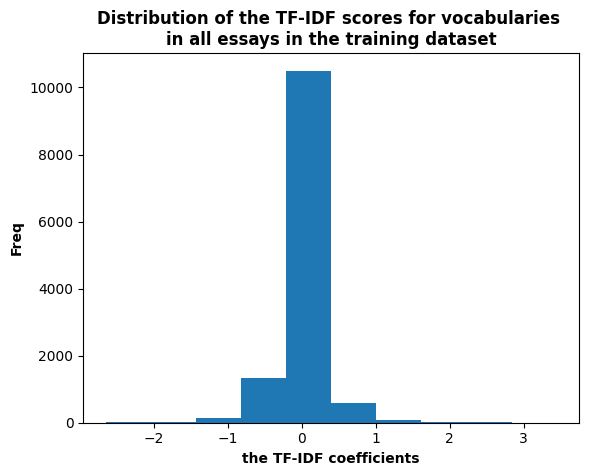

In [57]:
plt.hist(coef_df['coefficients'])
plt.xlabel('the TF-IDF coefficients', fontweight='bold')
plt.ylabel('Freq', fontweight='bold')
plt.title("Distribution of the TF-IDF scores for vocabularies \nin all essays in the training dataset", fontweight='bold')

plt.show()

#### Plot 1
**Explaination**:  
Since we know that:  
```
Each coefficient shows the how strongly the word discriminates between the two labels.  
1. The lower coefficients tending to classify the essay into label 0  
2. The higher coefficients tending to classify the essay into label 1
```
In the distribution plot above, it's evident that most coefficients are clustered around 0, indicating weak association with any specific label. To focus on words strongly related to each label, I've chosen to set boundaries for separating words with coefficients that are higher in relation to human-written essays and those with coefficients higher in relation to AI-generated essays. After analyzing the overall distribution of TF-IDF coefficients, I believe that -0.5 and 0.5 are suitable boundaries for my analysis purposes.




In [58]:
# seperate the ceof_df (coefficients, vocabulary) into human_coef and ai_coef
#    based on the coefficients
human_coef = coef_df[coef_df['coefficients'] <= -0.5] # the lower coefficients tending to classify the essay into 0 (human)
ai_coef = coef_df[coef_df['coefficients'] >= 0.5] # the higher coefficients tending to classify the essay into label 1 (ai)

To analyze the morphology of words in both labels, we will tokenize them and utilize the token.morph attribute to retrieve the morphology tags associated with each label. This process will allow us to examine the morphological features of words within each label category.

In [59]:
# empty list to collect all morphology tags for words in each dataset, human and ai
human_morph = []
ai_morph = []

human_coef_docs = list(nlp.pipe(human_coef.vocabulary)) # tokenize the vocabularies

for tokenized_doc in human_coef_docs:
  for token in tokenized_doc:
    if token.morph:    # for each token's morph tags, seperate them by "|"
        human_morph += str(token.morph).split('|')  # since each word might have multiple tags

# same process for the ai dataset
ai_coef_docs = list(nlp.pipe(ai_coef.vocabulary))

for tokenized_doc in ai_coef_docs:
  for token in tokenized_doc:
    if token.morph:
        ai_morph += str(token.morph).split('|')

Using a bar plot to display the counts of the same morphology tags for both labels is an effective choice for visualizing the morphology tags. This approach allows for a clear comparison of how each morphology tag is distributed across the different labels within the same plot.

In [60]:
from collections import Counter

human_morph_count = dict(sorted(Counter(human_morph).items())) # transform the Counter into dictionary with sorted morph tags
ai_morph_count = dict(sorted(Counter(ai_morph).items()))

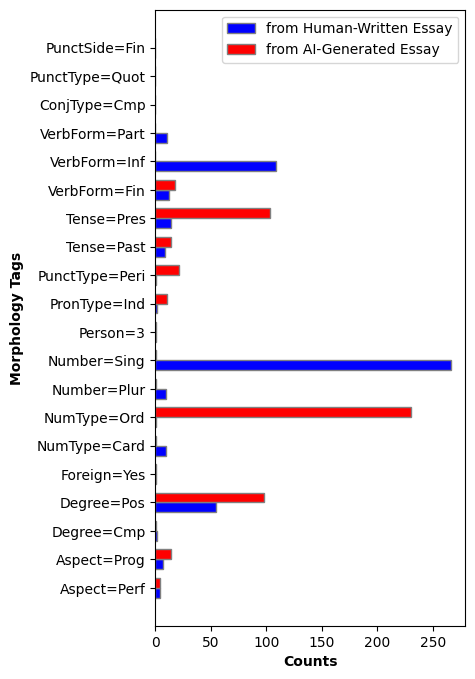

In [62]:
# get all unique keys from both Counters
keys_union = set(human_morph_count.keys()).union(set(ai_morph_count.keys()))

# ensure both Counters have counts for all keys, even if one has zero counts
human_morph_count.update({key: 0 for key in keys_union if key not in human_morph_count})
ai_morph_count.update({key: 0 for key in keys_union if key not in ai_morph_count})

# extract keys and values for both Counters (now with matching keys)
keys1, values1 = zip(*human_morph_count.items())
keys2, values2 = zip(*ai_morph_count.items())

# set width of bar
bar_height = 0.35

# set position of bar on Y axis
r1 = range(len(keys1))
r2 = [y + bar_height for y in r1]

# set the figure size
plt.figure(figsize=(4, 8))

# create horizontal bar plot
plt.barh(r1, values1, color='b', height=bar_height, edgecolor='grey', label='from Human-Written Essay')
plt.barh(r2, values2, color='r', height=bar_height, edgecolor='grey', label='from AI-Generated Essay')

# add yticks on the middle of the group bars
plt.xlabel('Counts', fontweight='bold')
plt.ylabel('Morphology Tags', fontweight='bold')
plt.yticks([r + bar_height / 2 for r in range(len(keys1))], keys1)

# create legend & Show graphic
plt.legend()
plt.show()

#### Plot 2

**Explanation**:  
In this plot, we can see some morphology tags are both human and ai related, like "Aspect=Prog" and "Aspect=Perf". But some tags have one higher than another, such as, "Degree=Pos", "Number=Sing", "VerbForm=Inf" v.s. "VerbForm=Fin", "Tense=Pres" v.s. "Tense=Past", and so on.

1. **AI related words have higher "Degree=Pos" than human related words**. This make sence if we think about when human write text, we tend to compare or exaggerate things we discribed with other things, which is subjective. For AI, it might describe a thing more objective than human.
2. **Human related words have higher "Number=Sing" than AI related words**. I think human writers often use singular nouns to personalize narratives or stories, focusing on the experiences, actions, or attributes of individual characters, objects, or phenomena. This personalized approach may result in a higher occurrence of singular forms.
3. **"VerbForm=Inf" v.s. "VerbForm=Fin"**: **Human-written text has a higher frequency of the "VerbForm=Inf"**, and **AI-generated text has a higher frequency of the "VerbForm=Fin"**. I explain this result as human writers often use infinitive forms for various purposes, such as expressing intentions, giving instructions, or describing hypothetical situations. AI models may struggle to accurately capture and generate these nuanced uses of infinitive forms without sufficient context understanding.
4. **"Tense=Pres" v.s. "Tense=Past"**: **Human-written text has a higher frequency of the "Tense=Pres"**, and **AI-generated text has a higher frequency of the "Tense=Past"**. This can be understand as human-written text often includes narratives, dialogues, and descriptions that require a mix of present and past tenses to convey events, actions, and thoughts effectively. AI-generated text may prioritize grammatical correctness and simplicity, resulting in a tendency towards simpler sentence structures with more straightforward verb tenses.

*Footnotes:  
What do those morphological tags mean?  
1. "Degree=Pos": Means positive degree. It is the base form of an adjective or adverb, often used to describe a quality or attribute without comparing it to anything else.
2. "Number=Sing": Means singlular form of the grammatical number of a word.
3. "VerbForm=Inf" & "VerbForm=Fin": Indicate inititive & finite forms of verbs.
4. "Tense=Pres" & "Tense=Past": Indicate different verb tenses

# Discussion

**Summarize of what I did**:  
The overarching goal of this research was to investigate the distinctiveness in word usage between AI-generated and human-written essays, with a focus on determining notable differences in word employment. We undertook a systematic data analysis and preprocessing phase, involving exploratory data analysis (EDA) to comprehend dataset structure and prepare for modeling. Tokenization and TF-IDF vectorization were applied to quantify word importance and set appropriate thresholds. Modeling efforts encompassed various classification algorithms, with SVM emerging as the most effective, accurately distinguishing between human-generated and AI-generated essays. The success of SVM in classifying based on TF-IDF matrices directly reinforces our research question, affirming that TF-IDF can indeed train models to discern human-written essays from AI-generated ones, marking a significant advancement in natural language processing and AI content generation studies.

**Key Takeaways**:    
The key takeaway from this analysis is the confirmation that TF-IDF matrices can indeed be leveraged to train models capable of distinguishing between human and AI-generated essays with a high degree of accuracy. This finding contributes valuable insights to the ongoing discourse on natural language processing and AI-driven content generation. Furthermore, the selection of SVM as the best-performing model underscores the importance of choosing appropriate algorithms for specific classification tasks.

# Conclusion

**Limitations**:

In our research, we gained valuable insights into distinguishing human-written and AI-generated essays using TF-IDF matrices and SVM classification. However, we must acknowledge several limitations:

1. Our reliance on a specific dataset limits the diversity of writing styles and topics across different domains.
2. The lack of information about data collection and sources may affect the credibility and applicability of our results.
3. The unknown prompts for the dataset used in this study could potentially impact our analysis results.
4. TF-IDF, while useful, has limitations such as not capturing word relationships and creating a large but sparse matrix due to numerous words.

**Future Work**:

To address these limitations and improve the effectiveness of TF-IDF-based models, future research could:

1. Use datasets with diverse topics and writing purposes across various domains, possibly collecting new data if necessary.
2. Explore additional linguistic features like phrasal complexity and semantic similarity.
3. Employ advanced machine learning techniques to enhance classification accuracy across different datasets.
4. Investigate contextual factors such as genre, language, and cultural nuances to broaden the scope and applicability of our findings.


These future steps aim to overcome limitations and strengthen TF-IDF-based models for better distinguishing between human-written and AI-generated content in natural language processing tasks.

# References

[1] Desaire, H., Chua, A. E., Isom, M., Jarosova, R., & Hua, D. (2023). Distinguishing academic science writing from humans or ChatGPT with over 99% accuracy using off-the-shelf machine learning tools. Cell reports. Physical science, 4(6), 101426. https://doi.org/10.1016/j.xcrp.2023.101426
[https://www.ncbi.nlm.nih.gov/pmc/articles/PMC10328544/]


In [ ]:
%%capture
!apt-get install texlive-xetex texlive-fonts-recommended texlive-plain-generic
!jupyter nbconvert --to pdf /content/drive/MyDrive/NLP-2024Spring/NLP-Project/Data_Assignment_2-TF_IDF/Data_Assignment2-Jiaying_Liang-TF-IDF.ipynb